In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def int_to_one_hot_tensor(x):
    return F.one_hot(torch.tensor(x), num_classes=10)

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=int_to_one_hot_tensor
)

input_layer_size = len(training_data[0][0].squeeze().flatten())
g = torch.Generator().manual_seed(42)

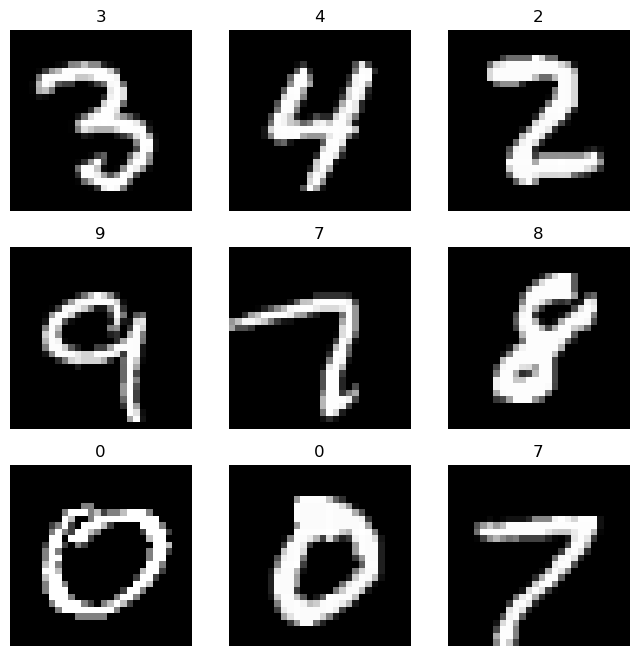

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(torch.argmax(label).item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
# 3-layer network:
# L1 - linear input layer
# L2 - tanh nonlinearity
# l3 - output logits layer

# Initialization

hidden_layer_size = 32
number_of_digits = 10

W1 = torch.randn((input_layer_size, hidden_layer_size), generator=g) # * 0.005 #* (5/3) / (((input_layer_size**0.5))) # linear params which will be input to tanh
#b1 = torch.randn(hidden_layer_size, generator=g) * 0.01
W2 = torch.randn((hidden_layer_size, number_of_digits), generator=g) * 0.5 # output (logits) layer params
b2 = torch.randn(number_of_digits, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))

parameters = [W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# Dataloaders initialization / setting batch size
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

25482


In [5]:
loss_snapshot = []
acc_snapshot = []
input_snapshot = []
ud_snapshot = []
step = []
snapshot_filter = 100
max_steps = 2000
lr = 0.001
optim = torch.optim.Adam(parameters, lr=lr)
for i in range(0, max_steps):
    train_features, train_labels = next(iter(train_dataloader))
    X = train_features.squeeze().reshape(-1, input_layer_size)
    L1 = X @ W1 # + b1

    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = L1.mean(0, keepdim=True)
    bnstdi = L1.std(0, keepdim=True)
    L1 = bngain * (L1 - bnmeani) / bnstdi + bnbias
    L1.retain_grad() # debug
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------    
    
    L2 = torch.tanh(L1)   # todo: torchify
    L2.retain_grad() # debug
    L3 = L2 @ W2 + b2
    L3.retain_grad() # debug
    loss = F.cross_entropy(L3, train_labels.float())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % snapshot_filter == 0:
        step.append(i)
        loss_snapshot.append(loss.item())
        softmax = torch.exp(F.log_softmax(L3, dim=1))
        acc = torch.mean(100*(1 - torch.sum((train_labels - (softmax * train_labels)), dim=1)))
        acc_snapshot.append(acc.item())
        input_snapshot.append(X)
        with torch.no_grad():
            ud_snapshot.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        


      0/   2000: 3.5040
    100/   2000: 1.6949
    200/   2000: 1.4088
    300/   2000: 0.9642
    400/   2000: 0.8835
    500/   2000: 0.6813
    600/   2000: 0.6778
    700/   2000: 0.5294
    800/   2000: 0.5262
    900/   2000: 0.3836
   1000/   2000: 0.3301
   1100/   2000: 0.2768
   1200/   2000: 0.3046
   1300/   2000: 0.3418
   1400/   2000: 0.4471
   1500/   2000: 0.3878
   1600/   2000: 0.6279
   1700/   2000: 0.1952
   1800/   2000: 0.4052
   1900/   2000: 0.4884


20
mean +0.98, std 0.02, saturated: 85.32%
mean +0.98, std 0.02, saturated: 86.42%
mean +0.98, std 0.02, saturated: 86.20%
mean +0.98, std 0.02, saturated: 86.84%
mean +0.99, std 0.02, saturated: 88.14%
mean +0.98, std 0.02, saturated: 85.32%
mean +0.99, std 0.02, saturated: 86.40%
mean +0.98, std 0.02, saturated: 82.94%
mean +0.98, std 0.02, saturated: 85.47%
mean +0.99, std 0.02, saturated: 86.55%
mean +0.99, std 0.02, saturated: 86.39%
mean +0.98, std 0.02, saturated: 84.12%
mean +0.98, std 0.02, saturated: 85.07%
mean +0.98, std 0.02, saturated: 80.16%
mean +0.98, std 0.02, saturated: 86.43%
mean +0.99, std 0.02, saturated: 86.52%
mean +0.98, std 0.02, saturated: 86.74%
mean +0.98, std 0.02, saturated: 85.85%
mean +0.99, std 0.02, saturated: 86.60%
mean +0.98, std 0.02, saturated: 87.06%


Text(0.5, 1.0, 'Input distribution')

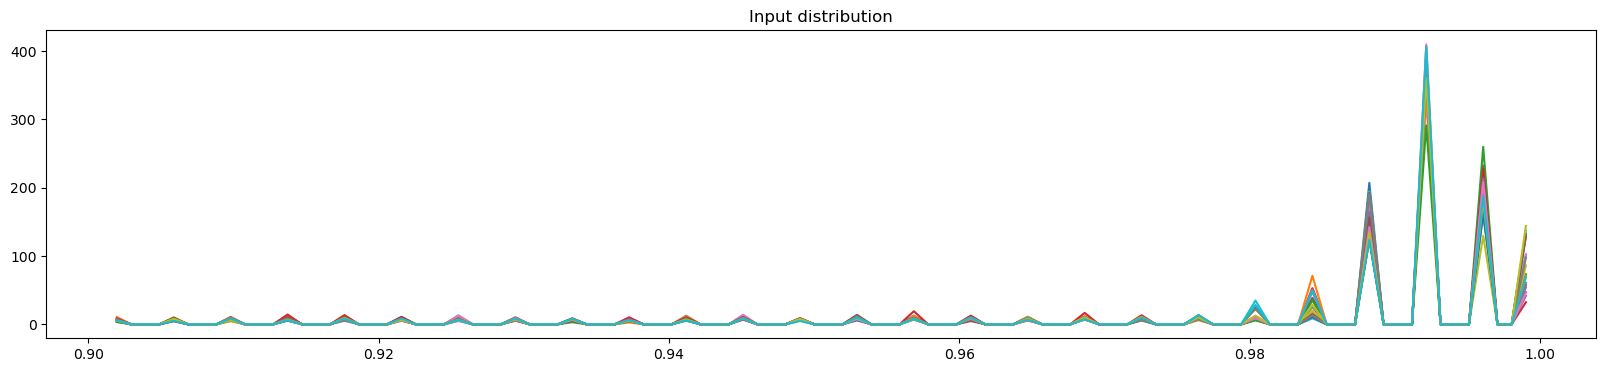

In [6]:
# Input historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
print(len(input_snapshot))
for x in input_snapshot:
    mask = x > 0.9
    t = x[mask]
    print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.title('Input distribution')

mean +0.03, std 1.13, saturated: 38.53%


Text(0.5, 1.0, 'L1 distribution')

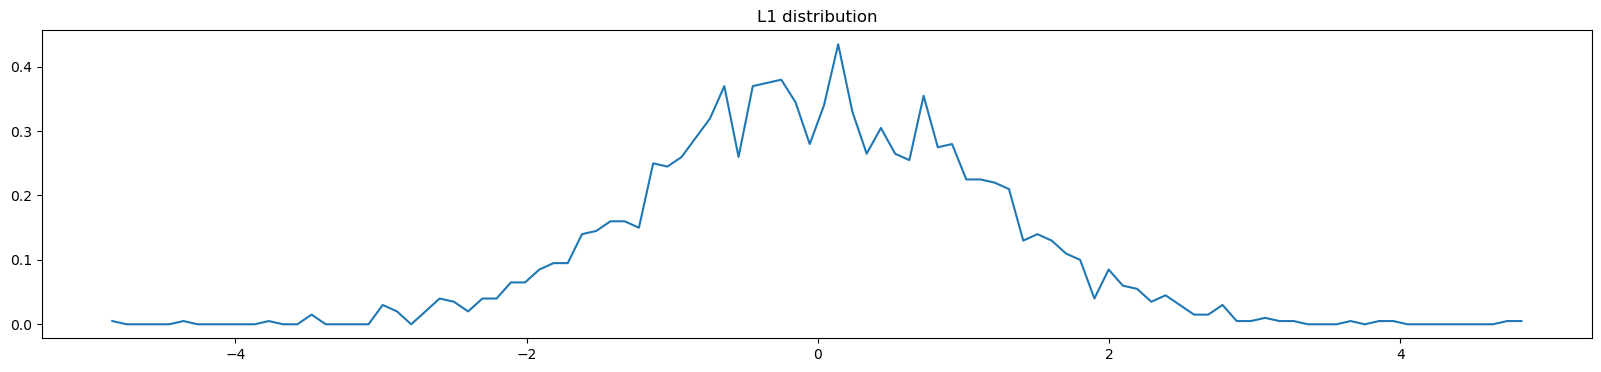

In [7]:
# L1 historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L1
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L1 distribution')

mean +0.02, std 0.66, saturated: 6.10%


Text(0.5, 1.0, 'L2 distribution')

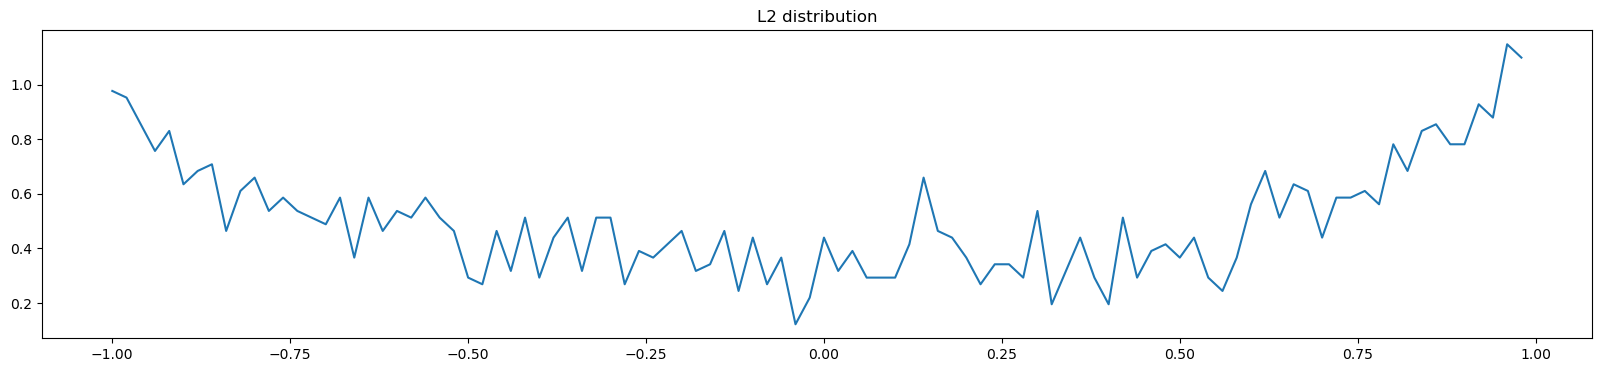

In [8]:
# L2 historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L2
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L2 distribution')

mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'L2 gradiend distribution')

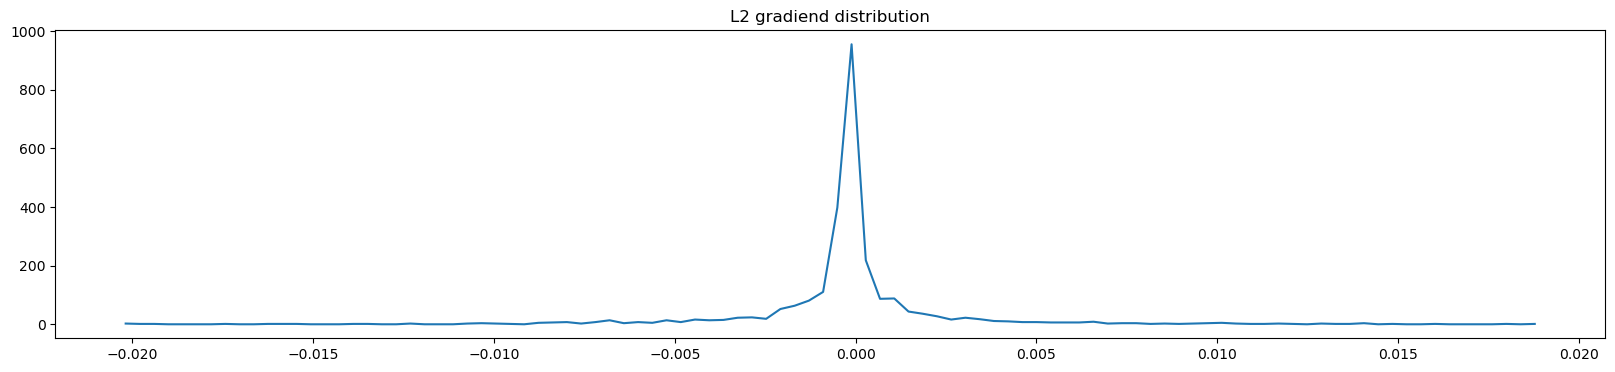

In [9]:
# L2.grad historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L2.grad
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L2 gradiend distribution')

mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'L1 gradiend distribution')

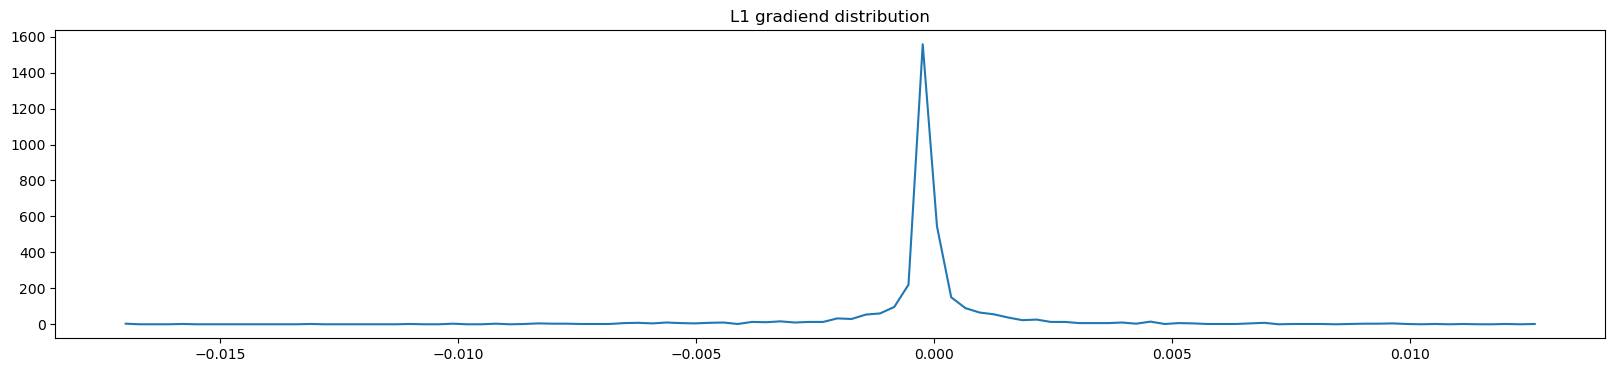

In [10]:
# L1.grad historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L1.grad
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L1 gradiend distribution')

mean +0.00, std 3.27, saturated: 75.47%


Text(0.5, 1.0, 'L3 distribution')

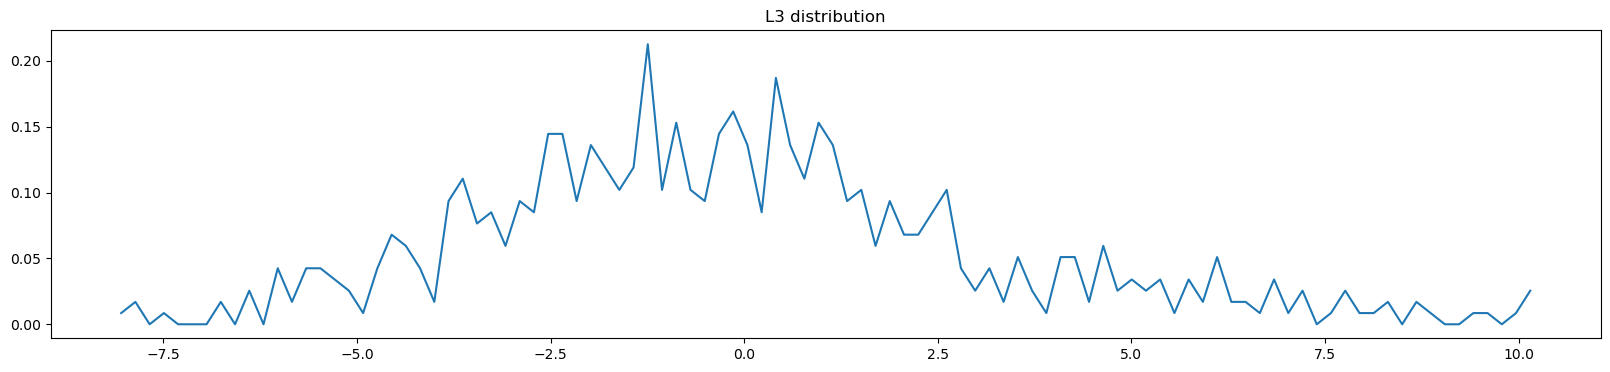

In [11]:
# L3 historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L3
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L3 distribution')

mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'L3 gradiend distribution')

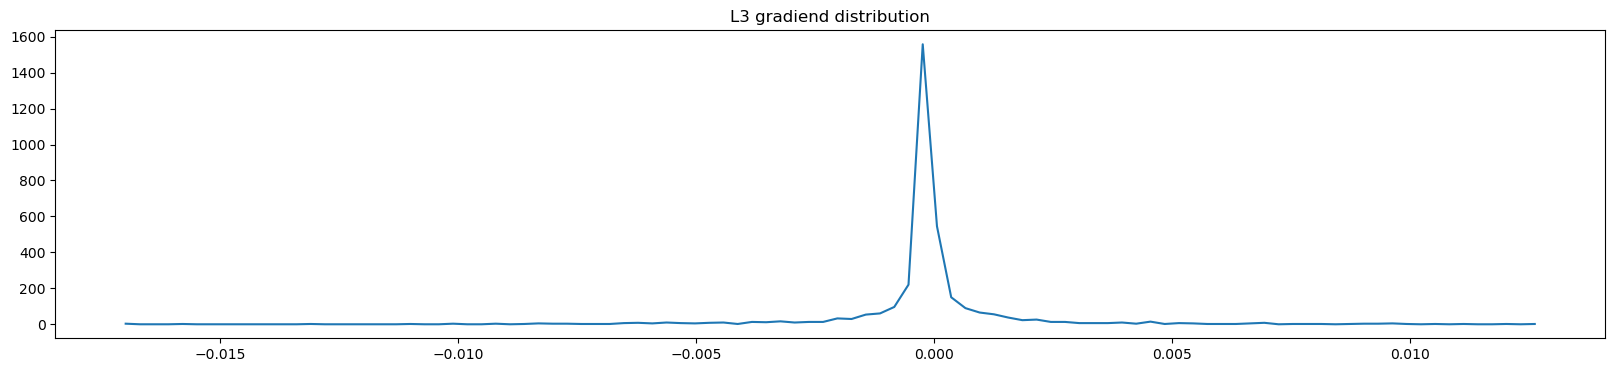

In [12]:
# L3.grad historgram
plt.figure(figsize=(20, 4)) # width and height of the plot
t = L1.grad
print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.title('L3 gradiend distribution')

weight  (784, 32) | mean -0.000004 | std 4.692678e-04 | grad:data ratio 4.665012e-04
weight   (32, 10) | mean +0.000000 | std 9.068070e-03 | grad:data ratio 1.563868e-02
weight    (1, 32) | mean -0.000768 | std 1.013486e-02 | grad:data ratio 4.603181e-02
weight    (1, 32) | mean -0.000760 | std 1.899212e-02 | grad:data ratio 1.136672e-01


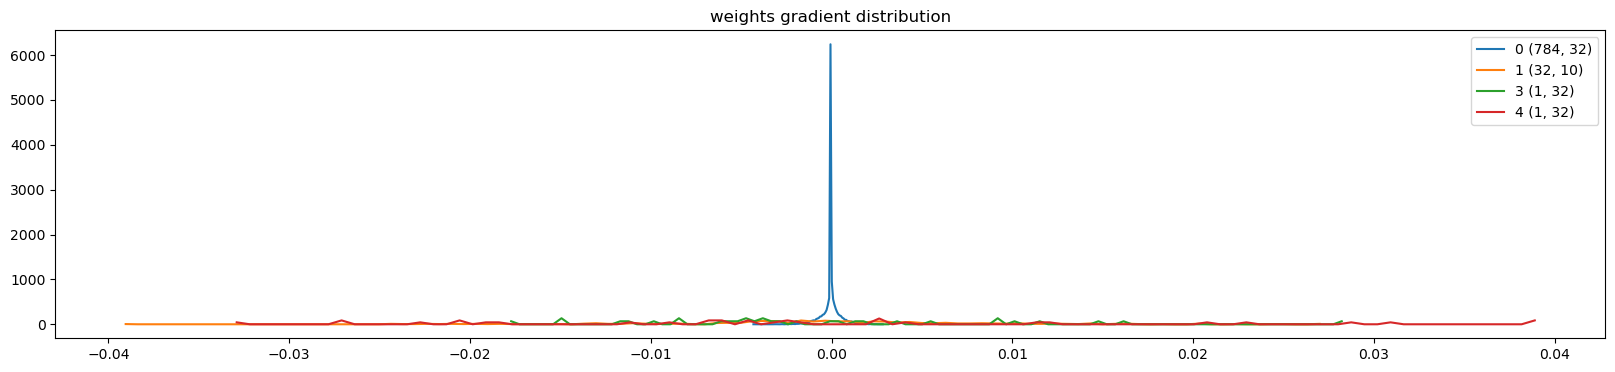

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

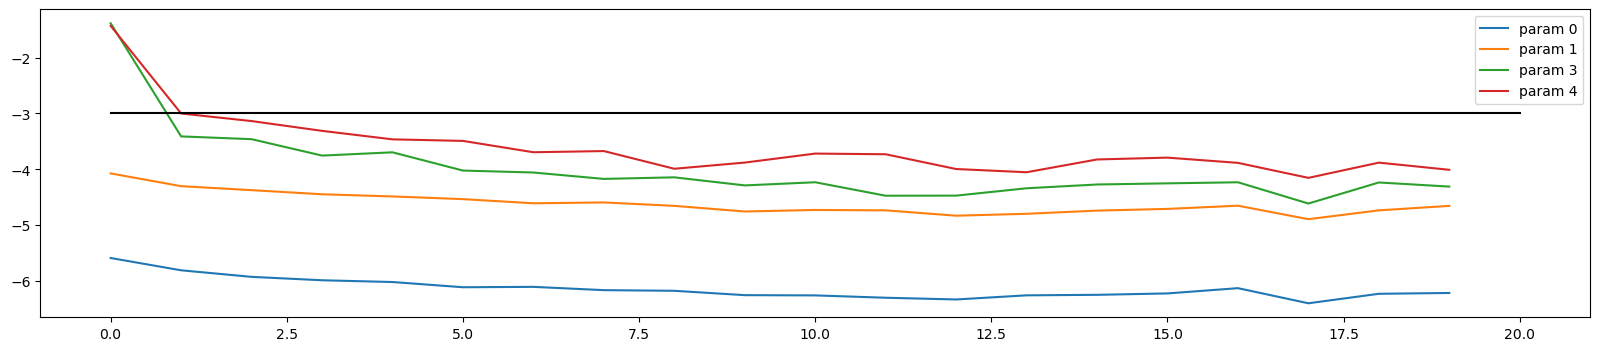

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud_snapshot[j][i] for j in range(len(ud_snapshot))])
    legends.append('param %d' % i)
plt.plot([0, len(ud_snapshot)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

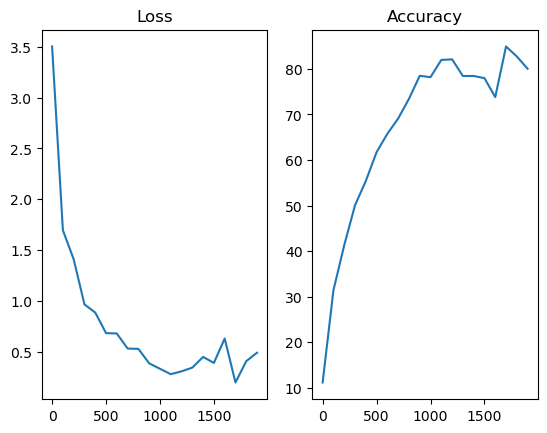

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(step, loss_snapshot)
ax2.set_title("Accuracy")
ax2.plot(step, acc_snapshot)

plt.show()

In [17]:
test_loss_snapshot = []
test_acc_snapshot = []
for i in range(0, 100):
    test_features, test_labels = next(iter(test_dataloader))
    X = test_features.squeeze().reshape(-1, input_layer_size)
    L1 = X @ W1 # + b1

    # BatchNorm layer
    # -------------------------------------------------------------
    L1 = bngain * (L1 - bnmean_running) / bnstd_running + bnbias
    # -------------------------------------------------------------    
    
    L2 = torch.tanh(L1)   # todo: torchify
    L3 = L2 @ W2# + b2
    loss = F.cross_entropy(L3, test_labels.float())
    test_loss_snapshot.append(loss.item())
    softmax = torch.exp(F.log_softmax(L3, dim=1))
    acc = torch.mean(100*(1 - torch.sum((test_labels - (softmax * test_labels)), dim=1)))
    test_acc_snapshot.append(acc.item())

print("loss: ", sum(test_loss_snapshot)/len(test_loss_snapshot))
print("acc: ", sum(test_acc_snapshot)/len(test_acc_snapshot))

loss:  0.34495307996869085
acc:  83.22604187011719


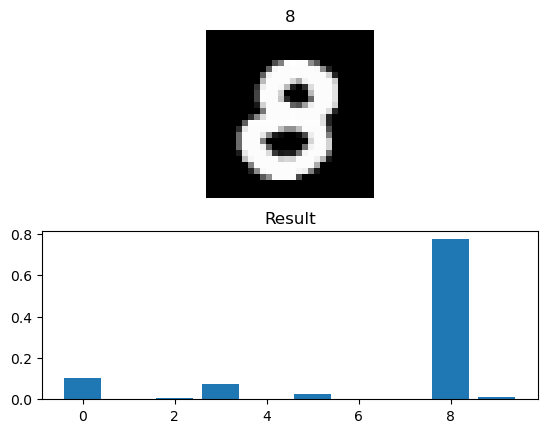

In [16]:
test_features, test_labels = next(iter(test_dataloader))
X = test_features.squeeze().reshape(-1, input_layer_size)
L1 = X @ W1 #+ b1

# BatchNorm layer
# -------------------------------------------------------------
L1 = bngain * (L1 - bnmean_running) / bnstd_running + bnbias
# -------------------------------------------------------------   

L2 = torch.tanh(L1)   # todo: torchify
L3 = L2 @ W2 # + b2
softmax = [s.item() for s in torch.exp(F.log_softmax(L3, dim=1)[0])]
img = test_features[0].squeeze()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title(torch.argmax(test_labels[0]).item())
ax1.axis("off")
ax1.imshow(img, cmap="gray")
ax2.set_title("Result")
number_labels = range(0, 10)
ax2.bar(number_labels, softmax)
plt.show()